In [8]:
from datasets import load_dataset, load_from_disk
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
from functools import reduce
import hashlib
from typing import List, Dict, Tuple
import ast
import pandas as pd
import numpy as np
import json

from langchain_text_splitters import CharacterTextSplitter, RecursiveCharacterTextSplitter

SAVE_DATASET_PATH = "../../data/qa_datasets/trivia_qa_rcwikipedia_validation/original"
SAVE_CONTEXTS_PATH = "../../data/qa_datasets/trivia_qa_rcwikipedia_validation/relevant_contexts.csv"
SAVE_TMP_CONTEXTS_PATH = "../../data/qa_datasets/trivia_qa_rcwikipedia_validation/tmp_triviaqa_cntx.csv"
SAVE_QA_PATH = "../../data/qa_datasets/trivia_qa_rcwikipedia_validation/qa_pairs.csv"
SAVE_STATS_PATH = "../../data/qa_datasets/trivia_qa_rcwikipedia_validation/stats.json"
CNTX_MAX_LEN = 1024
CNTX_MIN_LEN = 64
MAX_QA_PAIRS = 500

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=CNTX_MAX_LEN,
    separators=["\n\n"],
    chunk_overlap=64,
    length_function=len,
    is_separator_regex=False,
)

# text_splitter = CharacterTextSplitter(
#     separator="\n\n",
#     length_function=len,
#     is_separator_regex=False,
# )

#### Скачиваем датасет с Hugging Face

In [2]:
# https://huggingface.co/datasets/mandarjoshi/trivia_qa
valid_dataset = load_dataset("mandarjoshi/trivia_qa", "rc.wikipedia", split='validation') # 7990
valid_dataset.save_to_disk(SAVE_DATASET_PATH)

Saving the dataset (1/1 shards): 100%|██████████| 7993/7993 [00:06<00:00, 1159.49 examples/s]


In [9]:
valid_dataset = load_from_disk(SAVE_DATASET_PATH)

In [10]:
valid_dataset

Dataset({
    features: ['question', 'question_id', 'question_source', 'entity_pages', 'search_results', 'answer'],
    num_rows: 7993
})

#### Извлекаем все уникальные контексты (разбиваем их на чанки, т.к. они достаточно длинные)

In [5]:
base_contexts = list(map(lambda v: (v['title'], v['wiki_context']), valid_dataset['entity_pages']))

In [6]:
unique_splitted_contexts = dict()
contexts_qa_idxes = defaultdict(list)

process = tqdm(range(valid_dataset.num_rows))
scntx_counter = 0
for i in process:
    contexts = base_contexts[i]

    process.set_postfix_str(f"unique contexts: {len(unique_splitted_contexts)} / {scntx_counter}")

    for j,title in enumerate(contexts[0]): # titles
        if len(title) < 1:
            raise ValueError
        
        base_context = contexts[1][j] # context
        splitted_context = text_splitter.create_documents([base_context])

        for scntx in splitted_context:
            scntx_hash = hashlib.sha1(scntx.page_content.encode()).hexdigest()
        
            unique_splitted_contexts[scntx_hash] = (title, scntx.page_content)
            contexts_qa_idxes[scntx_hash].append(i)
            scntx_counter += 1

100%|██████████| 7993/7993 [00:10<00:00, 775.86it/s, unique contexts: 278384 / 506950]


In [7]:
cntx_df_dict = {'context': [], 'title': [],'qa_idxes': []}
for cntx_hash in contexts_qa_idxes.keys():
    cntx_df_dict['title'].append(unique_splitted_contexts[cntx_hash][0])
    cntx_df_dict['context'].append(unique_splitted_contexts[cntx_hash][1])
    cntx_df_dict['qa_idxes'].append(contexts_qa_idxes[cntx_hash])

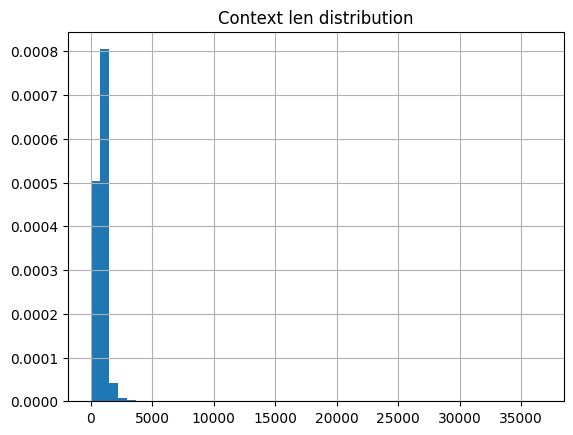

In [8]:
cntx_lens = list(map(lambda cntx: len(cntx), cntx_df_dict['context']))
plt.hist(cntx_lens, bins=50, density=True)
plt.title("Context len distribution")
plt.grid()
plt.show()

In [9]:
cntx_df = pd.DataFrame(cntx_df_dict)
cntx_df.to_csv(SAVE_TMP_CONTEXTS_PATH, index=False)

#### Фильтруем контексты по длине и максимальному количеству qa-пар

In [11]:
cntx_df = pd.read_csv(SAVE_TMP_CONTEXTS_PATH)
cntx_df['qa_idxes'] = cntx_df['qa_idxes'].map(lambda v: ast.literal_eval(v))

In [12]:
print(f"before: {cntx_df.shape}")

wolcnt_cntx_df = cntx_df[cntx_df['context'].str.len() <= CNTX_MAX_LEN].reset_index(drop=True)
print(f"after long contexts deletion: {wolcnt_cntx_df.shape}")

qa_idx_to_delete = set(reduce(lambda acc, v: acc + v, cntx_df[cntx_df['context'].str.len() > CNTX_MAX_LEN]['qa_idxes'].tolist(), []))
for i in tqdm(range(wolcnt_cntx_df.shape[0])):
    wolcnt_cntx_df.loc[i, 'qa_idxes'] =  list(set(wolcnt_cntx_df['qa_idxes'][i]).difference(qa_idx_to_delete))
wolcnt_cntx_df = wolcnt_cntx_df[wolcnt_cntx_df['qa_idxes'].str.len() > 0].reset_index(drop=True)
print(f"after incomplete contexts deletion: {wolcnt_cntx_df.shape}")

wolscnt_cntx_df = wolcnt_cntx_df[wolcnt_cntx_df['context'].str.len() >= CNTX_MIN_LEN].reset_index(drop=True)
print(f"after small contexts deletion: {wolcnt_cntx_df.shape}")

qa_idx_to_delete = set(reduce(lambda acc, v: acc + v, wolcnt_cntx_df[wolcnt_cntx_df['context'].str.len() < CNTX_MIN_LEN]['qa_idxes'].tolist(), []))
for i in tqdm(range(wolscnt_cntx_df.shape[0])):
    wolscnt_cntx_df.loc[i, 'qa_idxes'] =  list(set(wolscnt_cntx_df['qa_idxes'][i]).difference(qa_idx_to_delete))
wolscnt_cntx_df = wolscnt_cntx_df[wolscnt_cntx_df['qa_idxes'].str.len() > 0].reset_index(drop=True)
print(f"after incomplete contexts deletion: {wolscnt_cntx_df.shape}")

unique_qa_idxes = sorted(list(set(reduce(lambda acc, v: acc + v, wolscnt_cntx_df['qa_idxes'].tolist(), []))))[:MAX_QA_PAIRS]
for i in range(wolscnt_cntx_df.shape[0]):
    wolscnt_cntx_df.loc[i, 'qa_idxes'] =  list(set(wolscnt_cntx_df['qa_idxes'][i]).intersection(unique_qa_idxes))
filtered_cntx_df = wolscnt_cntx_df[wolscnt_cntx_df['qa_idxes'].str.len() > 0].reset_index(drop=True)
print(f"after ommiting qa-pairs: {filtered_cntx_df.shape}")

before: (278390, 3)
after long contexts deletion: (238052, 3)


100%|██████████| 238052/238052 [00:19<00:00, 12020.98it/s]


after incomplete contexts deletion: (10000, 3)
after small contexts deletion: (10000, 3)


100%|██████████| 9995/9995 [00:00<00:00, 10399.52it/s]


after incomplete contexts deletion: (9975, 3)
after ommiting qa-pairs: (4925, 3)


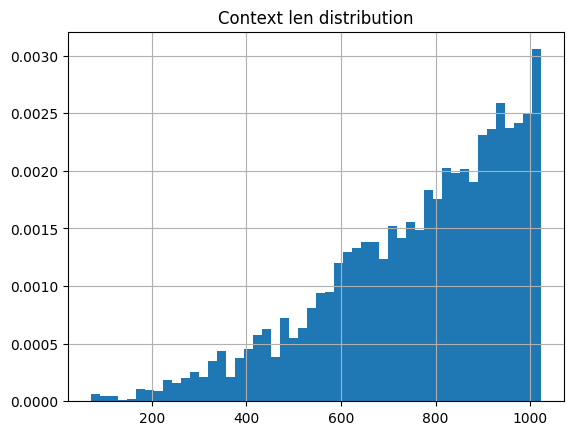

In [13]:
cntx_lens = list(map(lambda cntx: len(cntx), filtered_cntx_df['context']))
plt.hist(cntx_lens, bins=50, density=True)
plt.title("Context len distribution")
plt.grid()
plt.show()

In [14]:
filtered_cntx_df.to_csv(SAVE_CONTEXTS_PATH, index=False)

#### Формируем отдельный датасет с qa-парами (с учётом имеющегося набора отфильтрованных контекстов)

In [15]:
qa_df_dict = {'answer': [], 'question': [], 'qa_idx': []}

all_questions = valid_dataset['question']
all_answers = valid_dataset['answer']

for qa_idx in tqdm(unique_qa_idxes):
    qa_df_dict['answer'].append(all_answers[qa_idx]['value'])
    qa_df_dict['question'].append(all_questions[qa_idx])
    qa_df_dict['qa_idx'].append(qa_idx)

100%|██████████| 500/500 [00:00<00:00, 1034608.78it/s]


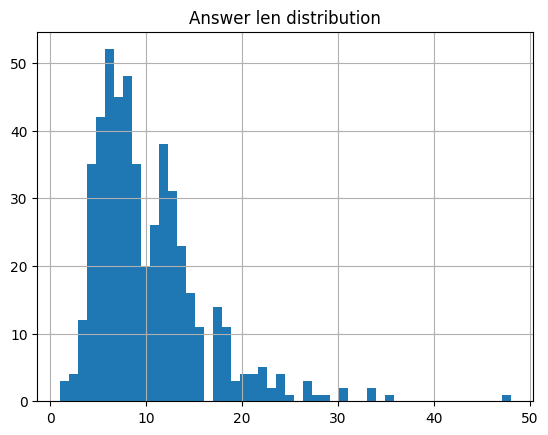

In [16]:
answer_lens = list(map(lambda cntx: len(cntx), qa_df_dict['answer']))
plt.hist(answer_lens, bins=50)
plt.title("Answer len distribution")
plt.grid()
plt.show()

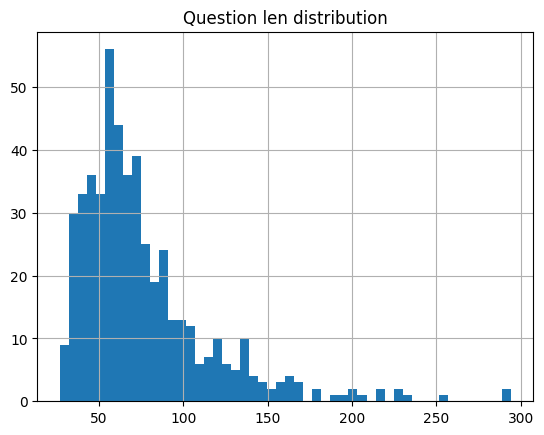

In [17]:
question_lens = list(map(lambda cntx: len(cntx), qa_df_dict['question']))
plt.hist(question_lens, bins=50)
plt.title("Question len distribution")
plt.grid()
plt.show()

In [18]:
qa_df = pd.DataFrame(qa_df_dict)
print(qa_df.shape)

(500, 3)


In [19]:
print("Количество уникальных вопросов: ", len(qa_df['question'].unique()))

Количество уникальных вопросов:  500


In [20]:
qa_df.to_csv(SAVE_QA_PATH, index=False)

#### Сохраняем статистику по полученным csv-файлам с контекстами и соответствующими qa-парами

In [21]:
def compute_stats(numbers: List[int]) -> Dict[str, float]:
    return {'median': round(np.median(numbers),5),
            'mean': round(np.mean(numbers),5),
            'std': round(np.std(numbers),5)}

In [22]:
filtered_ds_statistics = {
    'contexts_amount': filtered_cntx_df.shape[0],
    'contexts_len': compute_stats(list(map(lambda v: len(v), filtered_cntx_df['context'].tolist()))),
    'qa_pairs_amount': qa_df.shape[0],
    'answers_len':  compute_stats(list(map(lambda v: len(v), qa_df['answer'].tolist()))),
    'questions_len': compute_stats(list(map(lambda v: len(v), qa_df['question'].tolist())))
}

In [23]:
with open(SAVE_STATS_PATH, 'w', encoding='utf-8') as fd:
    json.dump(filtered_ds_statistics, fd, indent=1, ensure_ascii=False)